# Glasma field correlators
Extract $\langle E_z(\vec{x}_\perp)E_z(\vec{y}_\perp)\rangle x$ gauge inariant along a light-like jet trajectory.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"

In [2]:
import warnings
from numba.core.errors import NumbaPerformanceWarning

# Suppress the specific warning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [3]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
# os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('/n/work00/davrames/curraun/')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.qhat_correlators import JetFieldsCorrelators

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm


Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [4]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
# N = 256     # Number of lattice sites
DTS = 8     # Time step

# N = 128     # Number of lattice sites
# DTS = 4     # Time step
n_events = 1        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        
UV = 10.0       # Ultraviolet regulator [GeV] 

# taus = [0.01, 0.05, 0.1, 0.15, 0.3, 0.5]     # Formation times [GeV/fm]
# taus = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]
tau_max = 0.4    # Simulation time [GeV/fm]

In [5]:
# Define hbar*c [GeV*fm]
hbarc = 0.197326 

# def simulate():    
# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int((tau_max) / a) * DTS

# start of flux tube
# tau_start = a # 1st flux tube
# tau_start = 0.039 # 2nd flux tube
# tau_start = 0.054 # 3rd flux tube
tau_start = 0.06 # 4th flux tube
tstart = int((tau_start) / a) * DTS + 1

s = core.Simulation(N, DT, G)
mv.set_seed(124)
va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
initial.init(s, va, vb)

output = {}

fields = JetFieldsCorrelators(s)

if use_cuda:
    s.copy_to_device()

delta_tau = np.zeros(maxt // DTS)

elcorr = np.zeros((maxt // DTS, 3))
elcorr_all = np.zeros((maxt // DTS, N*N, 3))

magcorr = np.zeros((maxt // DTS, 3))
magcorr_all = np.zeros((maxt // DTS, N*N, 3))

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        core.evolve_leapfrog(s)
        
        if t % DTS == 0:
            EE_all, BB_all = fields.compute_corr(tstart)

            units = E0 ** 4

            # EE_all = fields.compute_elcorr()
            elcorr_all[t//DTS] = np.multiply(EE_all, units)

            EE = np.mean(EE_all, axis=0)
            EE *= units
            elcorr[t//DTS] = EE

            # BB_all = fields.compute_magcorr()
            magcorr_all[t//DTS] = np.multiply(BB_all, units)

            BB = np.mean(BB_all, axis=0)
            BB *= units
            magcorr[t//DTS] = BB

            delta_tau[t//DTS] = t / DTS * a

        pbar.update(1)
        
output['tau'], output['elcorr'], output['magcorr']  = delta_tau, elcorr, magcorr 

100%|██████████| 1632/1632 [01:20<00:00, 20.38it/s]


In [6]:
flux_tube = 4
with open(f'eik_jet_el_mag_corr_1_ev_{flux_tube}_flux_tube.pickle', 'wb') as f:
    pickle.dump(output, f)

In [23]:
with open(f'eik_jet_el_mag_corr_1_ev_{flux_tube}_flux_tube.pickle', 'rb') as f:
    data = pickle.load(f)  

tau = data['tau']
elcorr = data['elcorr']
magcorr = data['magcorr']

---
### Plot correlator in flux tubes, extract flux tube parameters

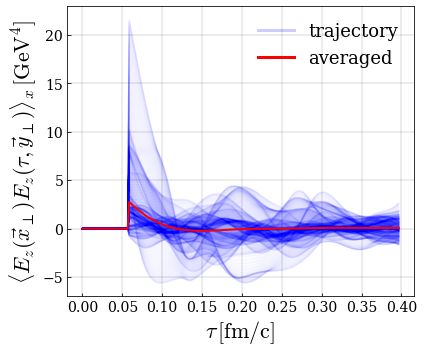

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, elcorr_all[:, 0:N, 2], color='blue', alpha=0.02, linewidth=1.5)
plt.plot(delta_tau, elcorr[:, 2], color='red', linewidth=2)


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
# plt.title(r'$elcorr$ as a function of $\Delta \tau$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([-40, 0, 40, 80, 120])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend_handles = [
    Line2D([0], [0], color='blue', alpha=0.2, linewidth=3, label='trajectory'),
    Line2D([0], [0], color='red', linewidth=3, label='averaged') 
]
plt.legend(handles=legend_handles, fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('ezcorr_lightlike.png', dpi=900, facecolor='w')
# plt.savefig('ezcorr_lightlike.pdf', facecolor='w')

plt.show()

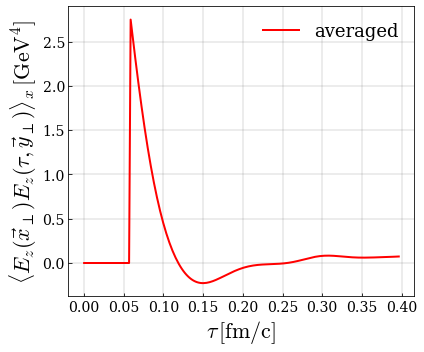

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, elcorr[:, 2], color='red', linewidth=2, label='averaged')


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
# plt.title(r'$elcorr$ as a function of $\Delta \tau$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim([0, 0.3])
# plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 4, 8, 12])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# legend_handles = [
#     # Line2D([0], [0], color='blue', alpha=0.2, linewidth=3, label='trajectory'),
#     Line2D([0], [0], color='red', linewidth=3, label='averaged') 
# ]
plt.legend(fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('ezcorr_lightlike_avg.png', dpi=900, facecolor='w')
# plt.savefig('ezcorr_lightlike_avg.pdf', facecolor='w')

plt.show()

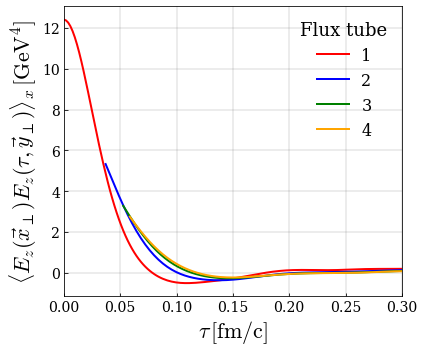

In [28]:
import pickle
import numpy as np

import matplotlib.pyplot as plt

# Initialize lists to store data from all files
all_tau = []
all_elcorr = []

# Loop through the files
for i in range(1, 5):
    with open(f'eik_jet_el_mag_corr_1_ev_{i}_flux_tube.pickle', 'rb') as f:
        data = pickle.load(f)
        tau = data['tau']
        elcorr = data['elcorr'][:, 2]  # Extract the third component of elcorr
        
        # Cut elcorr when the values are 0
        mask = elcorr != 0
        all_tau.append(tau[mask])
        all_elcorr.append(elcorr[mask])

# Plot the data for each flux tube
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

plt.xlim([0, 0.3])

colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    plt.plot(all_tau[i], all_elcorr[i], color=colors[i], linewidth=2, label=f'{i+1}')

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.legend(fontsize=16, frameon=False, title='Flux tube', title_fontsize=18, loc='upper right')
plt.tight_layout()

plt.savefig('ezcorr_lightlike_avg_4_flux_tubes.png', dpi=900, facecolor='w')
plt.show()

Fitted parameters: a = 6.498416471476431, b = 249.06785092051877


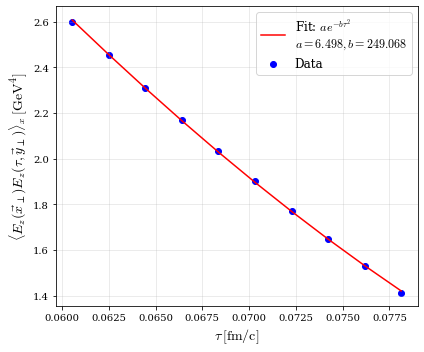

In [25]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the fitting function
def exp_fit(tau, a, b):
    return a * np.exp(-b * tau**2)

# Define the slice range
# 1st tube
# delta_tau_1 = 0.00  # Start of the slice
# delta_tau_2 = 0.07  # End of the slice

# 2nd tube
# delta_tau_1 = 0.039  # Start of the slice
# delta_tau_2 = 0.08  # End of the slice

# 3rd tube
# delta_tau_1 = 0.054  # Start of the slice
# delta_tau_2 = 0.09  # End of the slice

# 4th tube
delta_tau_1 = 0.06  # Start of the slice
delta_tau_2 = 0.08  # End of the slice

# Extract the slice
mask = (delta_tau >= delta_tau_1) & (delta_tau <= delta_tau_2)
delta_tau_slice = delta_tau[mask]
elcorr_slice = elcorr[mask, 2]

# Perform the curve fitting
popt, pcov = curve_fit(exp_fit, delta_tau_slice, elcorr_slice)

# Extract the fitted parameters
a, b = popt
print(f"Fitted parameters: a = {a}, b = {b}")

# Plot the data and the fit
plt.figure(figsize=(6, 5))
plt.scatter(delta_tau_slice, elcorr_slice, label="Data", color="blue")
plt.plot(delta_tau_slice, exp_fit(delta_tau_slice, a, b), label=f"Fit: $a e^{{-b \\tau^2}}$\n$a={a:.3f}, b={b:.3f}$", color="red")
plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=14)
plt.ylabel(r"$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
tau_e = np.sqrt(1 / b)
print(f"Exponential time scale: {tau_e:.3f} fm/c")
print(f"Value at exponential time scale: {exp_fit(tau_e, a, b):.3f} GeV^4")
tau_hm = np.sqrt(np.log(2) / b)
print(f"Half maximum time scale: {tau_hm:.3f} fm/c")
print(f"Value at half maximum: {exp_fit(tau_hm, a, b):.3f} GeV^4")
p = 0.9
tau_p = np.sqrt(-np.log(1-p) / b)
print(f"Percentage time scale (p={p}): {tau_p:.3f} fm/c")
print(f"Value at percentage time scale: {exp_fit(tau_p, a, b):.3f} GeV^4")

Exponential time scale: 0.063 fm/c
Value at exponential time scale: 2.391 GeV^4
Half maximum time scale: 0.053 fm/c
Value at half maximum: 3.249 GeV^4
Percentage time scale (p=0.9): 0.096 fm/c
Value at percentage time scale: 0.650 GeV^4


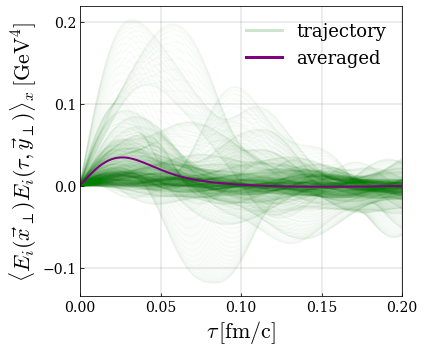

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

# plt.plot(delta_tau, magcorr_all[:, 0:N, 2], color='green', alpha=0.02, linewidth=1.5)
# plt.plot(delta_tau, magcorr[:, 2], color='purple', linewidth=2)

plt.plot(delta_tau, 2 * elcorr_all[:, 0:N, 0], color='green', alpha=0.02, linewidth=1.5)
plt.plot(delta_tau, 2 * elcorr[:, 0], color='purple', linewidth=2)


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_i(\vec{x}_\perp)E_i(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([-0.1, 0, 0.1, 0.2])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend_handles = [
    Line2D([0], [0], color='green', alpha=0.2, linewidth=3, label='trajectory'),
    Line2D([0], [0], color='purple', linewidth=3, label='averaged') 
]
plt.legend(handles=legend_handles, fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('bzcorr_lightlike.png', dpi=900, facecolor='w')
# plt.savefig('eicorr_lightlike.pdf', facecolor='w')

plt.show()

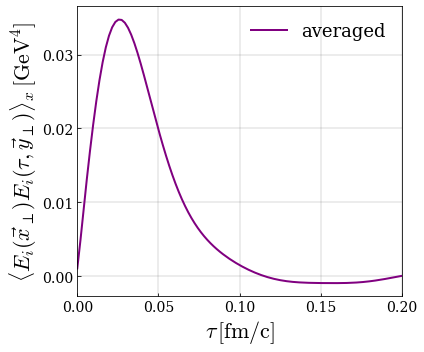

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, 2 * elcorr[:, 0], color='purple', linewidth=2, label='averaged')


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_i(\vec{x}_\perp)E_i(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

plt.legend(fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('bzcorr_lightlike_avg.png', dpi=900, facecolor='w')
# plt.savefig('eicorr_lightlike_avg.pdf', facecolor='w')

plt.show()

---
Classical $\hat{q}$ with or without transverse components

In [1]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

import sys
sys.path.append('/n/work00/davrames/curraun/')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm

from curraun.qhat import TransportedForce
from curraun.qhat_correlators import LongTransportedForce

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [2]:
# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
DTS = 8     # Time step

# N = 128     # Number of lattice sites
# DTS = 4     # Time step
n_events = 10        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        
UV = 10.0       # Ultraviolet regulator [GeV] 

# taus = [0.01, 0.05, 0.1, 0.15, 0.3, 0.5]     # Formation times [GeV/fm]
# taus = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]
tau_max = 1.0    # Simulation time [GeV/fm]

In [3]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_max / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, G)
    mv.set_seed(124)
    va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat = TransportedForce(s)
    qhat_long = LongTransportedForce(s)
    mom_broad, mom_broad_long, tau =  [], [], []

    if use_cuda:
        qhat.copy_to_device()
        qhat_long.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat.copy_mean_to_host()
                    qhat_long.copy_mean_to_host()

                # Units GeV^2
                mom_broad.append(qhat.p_perp_mean * E0 ** 2)
                mom_broad_long.append(qhat_long.p_perp_mean * E0 ** 2)

                tau.append(t / DTS * a)
                
                if use_cuda:
                    qhat.copy_mean_to_device()
                    qhat_long.copy_mean_to_device()
            qhat.compute()
            qhat_long.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, mom_broad_long, tau

In [5]:
nevents = 5

mom_broads, mom_broads_long = [], []
for ev in range(nevents):
    mom_broad_ev, mom_broad_long_ev, tau = simulate_qhat(ev)
    mom_broads.append(mom_broad_ev)
    mom_broads_long.append(mom_broad_long_ev)

mom_broad = np.mean(mom_broads, axis=0)
mom_broad_long = np.mean(mom_broads_long, axis=0)

Event 5: 100%|██████████| 4096/4096 [09:30<00:00,  7.18it/s]


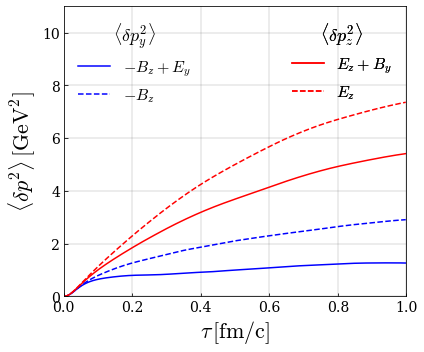

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

labels = [r'$E_y-B_z$', r'$E_z+B_y$']
labels_long = [r'$-B_z$', r'$E_z$']
colors = ['blue', 'red']

for i in [1,2]:
    plt.plot(tau, mom_broad[:, i], color=colors[i-1])
    plt.plot(tau, mom_broad_long[:, i], color=colors[i-1], linestyle='--')

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle \delta p^2\rangle\,\mathrm{[GeV^2]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1.0])
plt.ylim([0, 11])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# plt.legend(fontsize=18, frameon=False)

legend1 = plt.legend(handles=[plt.Line2D([0], [0], color='blue', linestyle='-', label=r'$-B_z+E_y$'),
                              plt.Line2D([0], [0], color='blue', linestyle='--', label=r'$-B_z$')],
                     title=r'$\langle \delta p^2_y\rangle$', title_fontsize=18, fontsize=16, frameon=False, loc='upper left')

plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='-', label=r'$E_z+B_y$'),
                              plt.Line2D([0], [0], color='red', linestyle='--', label=r'$E_z$')],
                     title=r'$\langle \delta p^2_z\rangle$', title_fontsize=18, fontsize=16, frameon=False, loc='upper right')

plt.gca().add_artist(legend2)

plt.tight_layout()

# plt.savefig('mom_broad_eb_contrib.pdf', facecolor='w')
plt.savefig('mom_broad_eb_contrib.png', dpi=900, facecolor='w')

plt.show()

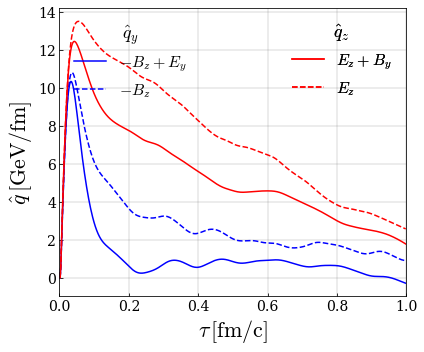

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

labels = [r'$E_y-B_z$', r'$E_z+B_y$']
labels_long = [r'$-B_z$', r'$E_z$']
colors = ['blue', 'red']

for i in [1,2]:
    qhat = np.diff(mom_broad[:, i]) / np.diff(tau)
    plt.plot(tau[1:len(tau)], qhat, color=colors[i-1])
    
    qhat_long = np.diff(mom_broad_long[:, i]) / np.diff(tau)
    plt.plot(tau[1:len(tau)], qhat_long, color=colors[i-1], linestyle='--')

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\hat{q}\,\mathrm{[GeV/fm]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1.0])
# plt.ylim([0, 11])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# plt.legend(fontsize=18, frameon=False)

legend1 = plt.legend(handles=[plt.Line2D([0], [0], color='blue', linestyle='-', label=r'$-B_z+E_y$'),
                              plt.Line2D([0], [0], color='blue', linestyle='--', label=r'$-B_z$')],
                     title=r'$\hat{q}_y$', title_fontsize=18, fontsize=16, frameon=False, loc='upper left')

plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='-', label=r'$E_z+B_y$'),
                              plt.Line2D([0], [0], color='red', linestyle='--', label=r'$E_z$')],
                     title=r'$\hat{q}_z$', title_fontsize=18, fontsize=16, frameon=False, loc='upper right')

plt.gca().add_artist(legend2)

plt.tight_layout()

# plt.savefig('qhat_eb_contrib.pdf', facecolor='w')
plt.savefig('qhat_eb_contrib.png', dpi=900, facecolor='w')

plt.show()